<a href="https://colab.research.google.com/github/kmvenkatesh04/Data-Science-Engg/blob/master/SEM2/ACI/Bayesian_Model_Aswin_Cricket_Analysis_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nodes for Bayesian network:

*   Test Location (Home, Away)
*   Aswin Playing (Yes, No)
*   Toss (Win, Loss, Draw)
*   Batting (1st, 2nd)
*   Result (Win, Loss, Draw)


In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive') """

Install Pomogranate module

In [ ]:
!pip install pomegranate

Importing necessary modules

In [91]:
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
from pomegranate import *

sns.set_style('whitegrid')
%matplotlib inline


Load input data file and get the file info & attributes

In [92]:
AswnIndTestData = pd.read_excel('/content/drive/My Drive/ColabDataInputs/India_Test_Stats.xlsx',sheet_name='Sheet1')
print('The shape of the data is ',AswnIndTestData.shape)
print('The details of the data set are \n')
print(AswnIndTestData.info())

The shape of the data is  (85, 8)
The details of the data set are 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Ashwin      85 non-null     object        
 1   Result      85 non-null     object        
 2   Margin      85 non-null     object        
 3   Toss        85 non-null     object        
 4   Bat         85 non-null     object        
 5   Opposition  85 non-null     object        
 6   Location    85 non-null     object        
 7   Start Date  85 non-null     datetime64[ns]
dtypes: datetime64[ns](1), object(7)
memory usage: 5.4+ KB
None


In [ ]:
AswnIndTestData[AswnIndTestData.Opposition == 'v Australia'].head()

In [93]:
df = AswnIndTestData.copy()

Changing the attribute names in the below fashion

*   Test Location - TLoc
*   Aswin Playing (Yes, No) - Aswin
*   Toss (Win, Loss, Draw) - Toss
*   Batting (1st, 2nd) - Bat
*   Result (Win, Loss, Draw) - Result

In [94]:
AttribChose = ['Location', 'Ashwin', 'Toss', 'Bat', 'Result']
AttribVals = {i:list(AswnIndTestData[i].unique()) for i in AttribChose}
AttribInp = {}

def getInput(attribval,attrib):
  print('**************************************************************\n')
  print('Choose any of the values {} for {}'.format(attribval,attrib))
  InputVal = input('')
  return InputVal

"""
for i in range(len(AttribChose)):
  a = getInput(AttribVals[AttribChose[i]],AttribChose[i])
  while a not in AttribVals[AttribChose[i]]:
    print('You have entered an incorrect option. \nYou have entered {}.\nPlease check case and spelling and try againui'.format(a))
    a = getInput(AttribVals[AttribChose[i]],AttribChose[i])
  AttribInp[AttribChose[i]] = a

"""

"\nfor i in range(len(AttribChose)):\n  a = getInput(AttribVals[AttribChose[i]],AttribChose[i])\n  while a not in AttribVals[AttribChose[i]]:\n    print('You have entered an incorrect option. \nYou have entered {}.\nPlease check case and spelling and try againui'.format(a))\n    a = getInput(AttribVals[AttribChose[i]],AttribChose[i])\n  AttribInp[AttribChose[i]] = a\n\n"

In [153]:
def getDiscreteProba(df,attrib):
  attribcount = df[attrib].value_counts().to_dict()
  attribproba = {i:attribcount[i]/sum(attribcount.values()) for i in attribcount.keys()}
  #print(attribcount)
  return attribproba


def filterDF( InputVals , df):
  column = list(InputVals.keys())
  condition = list(InputVals.values())
  equal = ['==' for i in condition]
  query = ' & '.join(f'{i} {j} {repr(k)}' for i, j, k in zip(column, equal, condition))
  filterdf = df.query(query)
  return filterdf


def getCondProbab(filtervals,df, SummarAttrib = None, SummarAttribval = None):
  if SummarAttrib != None:
    tempDF = filterDF(filtervals, df)
  else:
    print('In else condition',filtervals)
    #discretevals = getDiscreteProba(df,filtervals)
    #condproblist = discretevals[list(filtervals.values())[0]]
    condproblist = getDiscreteProba(df,filtervals) 
    return condproblist
  if len(tempDF) > 0:
    TempDFPivt = pd.pivot_table(tempDF,index=[SummarAttrib],values=[list(filtervals.keys())[0]],aggfunc='count')
    TempDFPivt.reset_index(inplace = True)
    #print(len(TempDFPivt),'\n',TempDFPivt,'\n',list(a.keys())[0])
    #print('------------------------------------')
    TempDFPivt.rename(columns={list(filtervals.keys())[0]:'Count'},inplace = True)
    #print(len(TempDFPivt),'\n',TempDFPivt)
    #print('******************************************')
    CondProbabAll = {i:int(TempDFPivt[TempDFPivt[SummarAttrib] == i].Count)/sum(list(TempDFPivt['Count'])) for i in list(TempDFPivt[SummarAttrib])}
    condproblist = list(filtervals.values())
    condproblist.append(SummarAttribval)
    if SummarAttribval in CondProbabAll.keys():
      condproblist.append(CondProbabAll[SummarAttribval])
      #condproblist = condproblist +  CondProbabAll[list(CondprobAttr.values())[0]]
      return condproblist
    else:
      condproblist.append(float(0))
      #condproblist1 = list(itertools.chain(*condproblist))
      return condproblist
  else:
    #print('In Else condition')
    condproblist = list(filtervals.values())
    condproblist.append(SummarAttribval)
    condproblist.append(float(0))
    return condproblist

def CondProbMultiAttr(AttribChoose, df):
  CondprobAttrs = {}
  AllCombinations = []
  for i in range(len(AttribChoose)):
    tempAttr = (AttribChoose[:i])
    if len(tempAttr) >0:
      tempAttrVals = {i:list(df[i].unique()) for i in tempAttr}
      #print(AttribChoose[:i], AttribChoose[i])
      tempcondattr = {}
      tempcondattr[AttribChoose[i]] = df[AttribChoose[i]].unique()
      #print('The conditional attribute values ',tempcondattr)
      allNames = sorted(tempAttrVals)
      keys, values = zip(*tempAttrVals.items())
      permutations_dicts = [dict(zip(keys, v)) for v in it.product(*values)]
      tempcondprob = []
      for j in permutations_dicts:
        #print(j)
        for k in tempcondattr[AttribChoose[i]]:
          #print('***********************************\nFilter values and the conditional attrib values are ',j,AttribChoose[i],k,'\n')
          #print(getCondProbab(j, df, AttribChoose[i] ,k))
          tempcondprob.append(getCondProbab(j, df, AttribChoose[i] ,k))
      CondprobAttrs[str(AttribChoose[:i+1])] = tempcondprob
  return CondprobAttrs

In [ ]:
CondProbMultiAttr(['Location', 'Ashwin', 'Toss', 'Bat','Result'])

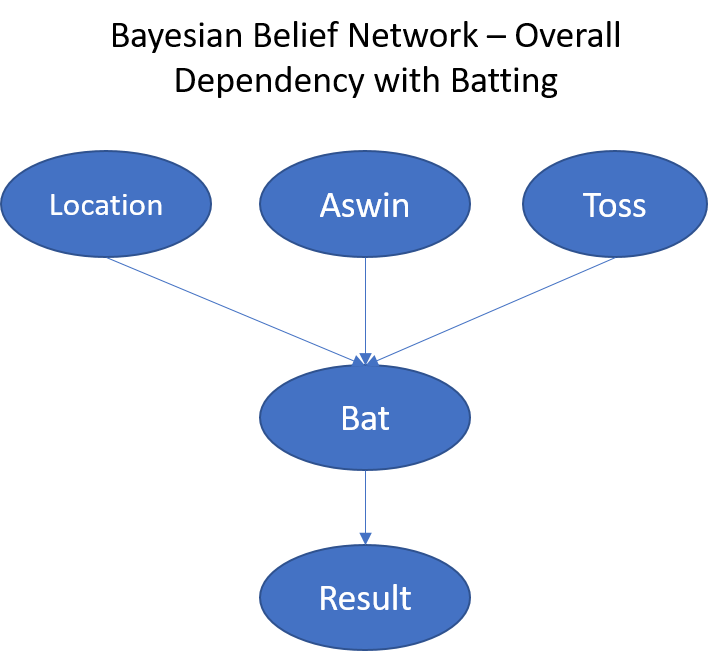

In [149]:
from IPython.display import Image
Image('/content/drive/My Drive/ColabDataInputs/BBNBat.png',width=500, height=500)

In [157]:
CondProbMultiAttr(['Bat', 'Result'],df)["['Bat', 'Result']"]


[['2nd', 'won', 0.41025641025641024],
 ['2nd', 'draw', 0.2564102564102564],
 ['2nd', 'lost', 0.3333333333333333],
 ['1st', 'won', 0.6739130434782609],
 ['1st', 'draw', 0.13043478260869565],
 ['1st', 'lost', 0.1956521739130435]]

In [178]:
BTLoc = DiscreteDistribution(getDiscreteProba(df,'Location'))
BAswin = DiscreteDistribution(getDiscreteProba(df,'Ashwin'))
BToss = DiscreteDistribution(getDiscreteProba(df,'Toss'))
BBat = ConditionalProbabilityTable(CondProbMultiAttr(['Location', 'Ashwin', 'Toss', 'Bat'],df)["['Location', 'Ashwin', 'Toss', 'Bat']"],[BTLoc, BAswin, BToss ])
BResult = ConditionalProbabilityTable(CondProbMultiAttr(['Bat', 'Result'],df)["['Bat', 'Result']"],[BBat])

s1 = Node(BTLoc, name="BLocation")
s2 = Node(BAswin, name="BAswin")
s3 = Node(BToss, name="BToss")
s4 = Node(BBat, name="BBat")
s5 = Node(BResult, name="BResult")

Bmodel = BayesianNetwork("Winning probablity of Aswin Playing in the game")
Bmodel.add_states(s1, s2, s3, s4, s5)
Bmodel.add_edge(s1, s4)
Bmodel.add_edge(s2, s4)
Bmodel.add_edge(s3, s4)
Bmodel.add_edge(s4, s5)

Bmodel.bake()

In [179]:
Bmodel.predict_proba([{'BAswin': 'Y', 'BLocation': 'Away'}])

[array(['Away', 'Y',
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "lost" : 0.5294117647058821,
             "won" : 0.47058823529411775
         }
     ],
     "frozen" : false
 },
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "2nd" : 0.36397058823529416,
             "1st" : 0.636029411764706
         }
     ],
     "frozen" : false
 },
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "draw" : 0.17628614991146968,
             "lost" : 0.24576406649616375,
             "won" : 0.5779497835923666
         }
     ],
     "frozen" : false
 }], dtype=object)]

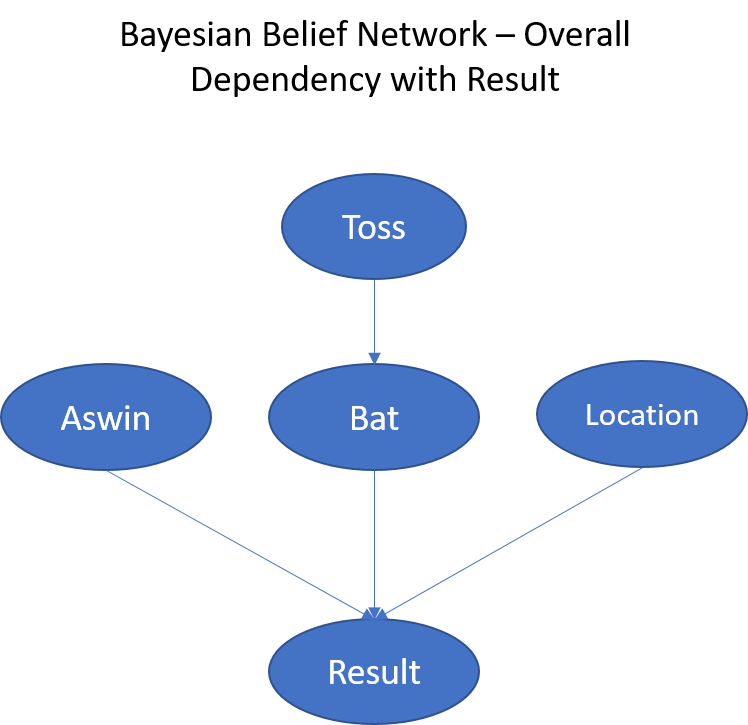

In [162]:
from IPython.display import Image
Image('/content/drive/My Drive/ColabDataInputs/BBNResult.png',width=500, height=500)

In [ ]:
CondProbMultiAttr(['Ashwin','Bat', 'Location','Result'],df)["['Ashwin', 'Bat', 'Location', 'Result']"]

In [185]:
RToss = DiscreteDistribution(getDiscreteProba(df,'Toss'))
RAswin = DiscreteDistribution(getDiscreteProba(df,'Ashwin'))
RTLoc = DiscreteDistribution(getDiscreteProba(df,'Location'))
RBat = ConditionalProbabilityTable(CondProbMultiAttr(['Toss', 'Bat'],df)["['Toss', 'Bat']"],[RToss])
RResult = ConditionalProbabilityTable(CondProbMultiAttr(['Ashwin','Bat', 'Location','Result'],df)["['Ashwin', 'Bat', 'Location', 'Result']"],[RAswin,RBat,RTLoc])

s1 = Node(RToss, name="RToss")
s2 = Node(RAswin, name="RAswin")
s3 = Node(RTLoc, name="RTLoc")
s4 = Node(RBat, name="RBat")
s5 = Node(RResult, name="RResult")

Rmodel = BayesianNetwork("Winning probablity of Aswin Playing in the game - 2")
Rmodel.add_states(s1, s2, s3, s4, s5)
Rmodel.add_edge(s1, s4)
Rmodel.add_edge(s2, s5)
Rmodel.add_edge(s3, s5)
Rmodel.add_edge(s4, s5)

Rmodel.bake()

In [187]:
Rmodel.predict_proba([{'RAswin': 'Y', 'RTLoc': 'Away'}])

[array([{
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "lost" : 0.5294117647058824,
             "won" : 0.47058823529411764
         }
     ],
     "frozen" : false
 },
        'Y', 'Away',
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "2nd" : 0.4588235294117648,
             "1st" : 0.5411764705882354
         }
     ],
     "frozen" : false
 },
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "draw" : 0.23449197860962576,
             "lost" : 0.46109625668449195,
             "won" : 0.3044117647058823
         }
     ],
     "frozen" : false
 }], dtype=object)]

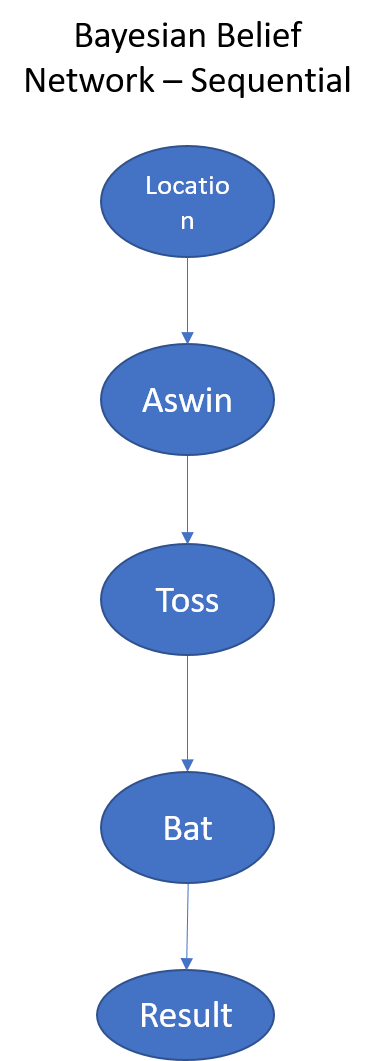

In [188]:
from IPython.display import Image
Image('/content/drive/My Drive/ColabDataInputs/BBNSequen.png',width=500, height=500)

In [ ]:
CondProbMultiAttr(['Bat','Result'],df)["['Bat', 'Result']"]

In [201]:
STLoc = DiscreteDistribution(getDiscreteProba(df,'Location'))
SAswin = ConditionalProbabilityTable(CondProbMultiAttr(['Location','Ashwin'],df)["['Location', 'Ashwin']"],[STLoc])
SToss = ConditionalProbabilityTable(CondProbMultiAttr(['Ashwin','Toss'],df)["['Ashwin', 'Toss']"],[SAswin])
SBat = ConditionalProbabilityTable(CondProbMultiAttr(['Toss','Bat'],df)["['Toss', 'Bat']"],[SToss])
SResult = ConditionalProbabilityTable(CondProbMultiAttr(['Bat','Result'],df)["['Bat', 'Result']"],[SBat])

s1 = Node(STLoc, name="STLoc")
s2 = Node(SAswin, name="SAswin")
s3 = Node(SToss, name="SToss")
s4 = Node(SBat, name="SBat")
s5 = Node(SResult, name="SResult")

Smodel = BayesianNetwork("Winning probablity of Aswin Playing in the game - 3")
Smodel.add_states(s1, s2, s3, s4, s5)
Smodel.add_edge(s1, s2)
Smodel.add_edge(s2, s3)
Smodel.add_edge(s3, s4)
Smodel.add_edge(s4, s5)

Smodel.bake()

In [202]:
Smodel.predict_proba([{'SAswin': 'Y', 'STLoc': 'Away'}])

[array(['Away', 'Y',
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "lost" : 0.5285714285714286,
             "won" : 0.4714285714285715
         }
     ],
     "frozen" : false
 },
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "2nd" : 0.4582539682539684,
             "1st" : 0.5417460317460318
         }
     ],
     "frozen" : false
 },
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "draw" : 0.18816354338093474,
             "lost" : 0.2587451115711986,
             "won" : 0.5530913450478667
         }
     ],
     "frozen" : false
 }], dtype=object)]

**Probability predictions with all the 3 Belief networks**

*   India winning, batting 2nd, Ashwin playing
*   India winning, batting 2nd, Ashwin not playing
*   India losing, batting 2nd, Ashwin playing
*   India losing, batting 2nd, Ashwin not playing



In [209]:
a,b,c,d = ['won','2nd','Y'], ['won','2nd','N'], ['lost','2nd','Y'], ['lost','2nd','N']
for i in [a,b,c,d]:
  print('\n With Belief network dependent on Batting Node \n')
  print(Bmodel.predict_proba([{'BResult' : i[0], 'BBat' : i[1], 'BAswin' : i[2]}]))
  print('\n With Belief network dependent on Result Node\n')
  print(Rmodel.predict_proba([{'RResult' : i[0], 'RBat' : i[1], 'RAswin' : i[2]}]))
  print('\nWith Belief network in Sequential Approach\n')
  print(Smodel.predict_proba([{'SResult' : i[0], 'SBat' : i[1], 'SAswin' : i[2]}]))
  print('\n==========================================================================================\n')


 With Belief network dependent on Batting Node 

[array([{
    "class" : "Distribution",
    "dtype" : "str",
    "name" : "DiscreteDistribution",
    "parameters" : [
        {
            "Home" : 0.6060823796036783,
            "Away" : 0.3939176203963218
        }
    ],
    "frozen" : false
},
       'Y',
       {
    "class" : "Distribution",
    "dtype" : "str",
    "name" : "DiscreteDistribution",
    "parameters" : [
        {
            "lost" : 0.9525969088578127,
            "won" : 0.04740309114218729
        }
    ],
    "frozen" : false
},
       '2nd', 'won'], dtype=object)]

 With Belief network dependent on Result Node

[array([{
    "class" : "Distribution",
    "dtype" : "str",
    "name" : "DiscreteDistribution",
    "parameters" : [
        {
            "lost" : 0.8974358974358972,
            "won" : 0.10256410256410273
        }
    ],
    "frozen" : false
},
       'Y',
       {
    "class" : "Distribution",
    "dtype" : "str",
    "name" : "DiscreteDistrib